First, we import all necessary libraries to handle data processing, visualization, and model building. Libraries like pandas and numpy help us manipulate data, while scikit-learn provides tools for machine learning models and performance evaluation.

In [1]:
# Import all required libraries
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, accuracy_score, roc_curve, auc,precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, label_binarize, LabelEncoder
import pickle


Next, we load the dataset and create a correlation heatmap to visually analyze the relationships between numeric features. This can give us insight into which features are most closely related.

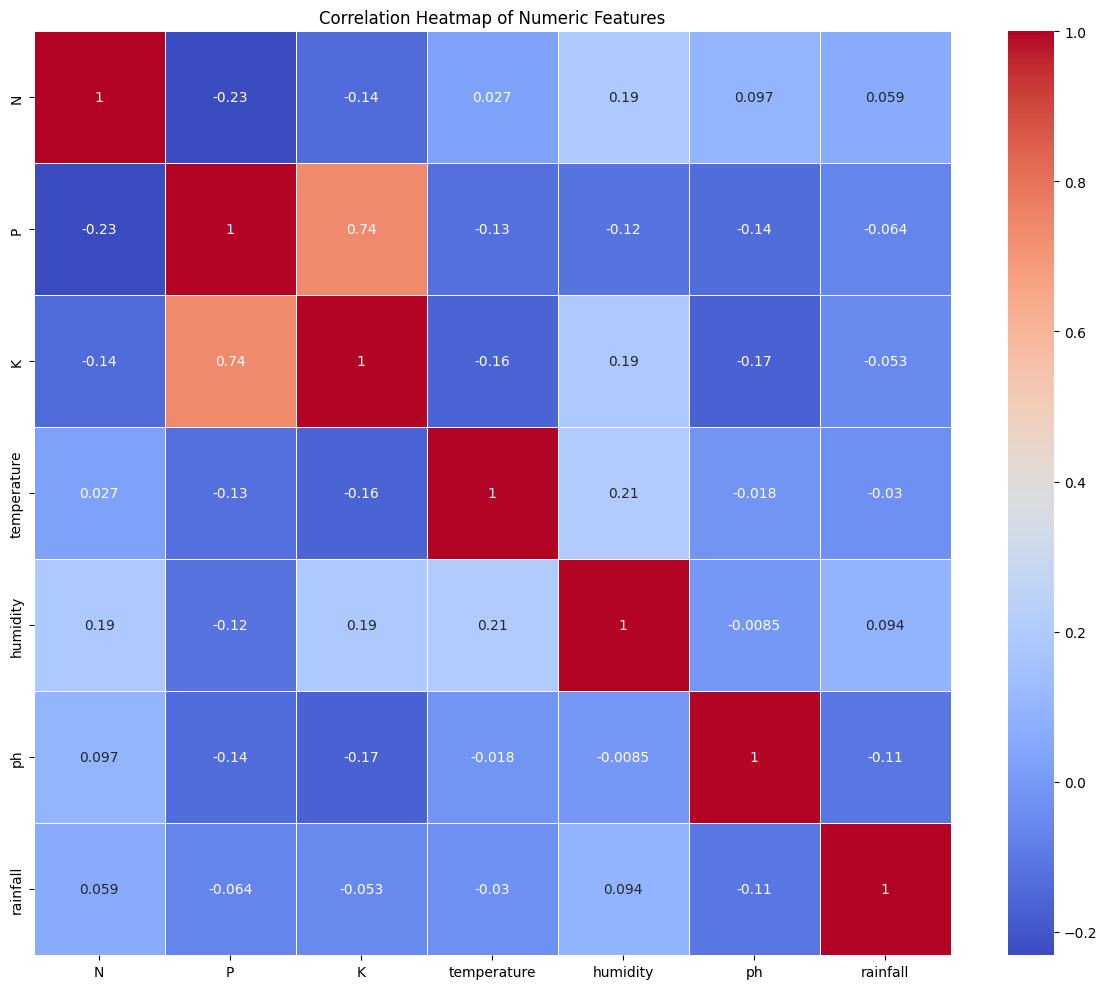

In [2]:
# Load and prepare dataset
df = pd.read_csv('modified_dataset.csv')

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), 
            annot=True, 
            cmap='coolwarm', 
            linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


After that, we select the input features and encode the target variable (crop labels) into numeric values. Encoding is essential for training machine learning models.

In [3]:
# Data preparation
features = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
target = df['label']

# Encode labels
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# Save label encoder for future use
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)


Then, we split the dataset into training and testing sets. This split allows us to train the models on one portion of the data and evaluate their performance on another, ensuring the models generalize well.

In [4]:
# Split data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features, target_encoded, test_size=0.2, random_state=2)

# Prepare for ROC curves
Ytest_binarized = label_binarize(Ytest, classes=np.arange(len(np.unique(Ytest))))


ollowing the split, we scale the feature values to a 0-1 range. Scaling helps improve model performance, particularly for algorithms sensitive to feature magnitude differences.

In [5]:
# Scale features
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(Xtrain)
X_test_norm = scaler.transform(Xtest)

# Save scaler for future use
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


Now, we define a function to train, evaluate, and save models. This function not only trains the model but also computes accuracy, precision, recall, and F1 score for evaluation. Each trained model is saved for easy reuse.



In [6]:
def train_save_model(model, model_name, Xtrain, Ytrain, Xtest, Ytest, normalize=False):
    """
    Train, evaluate, and save a model.
    Returns: model, accuracy, precision, recall, fscore
    """
    if normalize:
        model.fit(X_train_norm, Ytrain)
        predictions = model.predict(X_test_norm)
    else:
        model.fit(Xtrain, Ytrain)
        predictions = model.predict(Xtest)

    accuracy = accuracy_score(Ytest, predictions)
    precision, recall, fscore, _ = precision_recall_fscore_support(Ytest, predictions, 
                                                                   average='macro')

    print(f"\n{model_name} Accuracy: {accuracy}")
    print(classification_report(Ytest, predictions))

    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)

    return model, accuracy, precision, recall, fscore


Next, we train multiple models, each with different configurations. We save the results, including accuracy, precision, recall, and F1 score, to assess which model performs best.

In [7]:
# Train models
models = [
    ("Decision Tree", DecisionTreeClassifier(criterion="entropy", random_state=2, max_depth=5)),
    ("SVM", SVC(kernel='poly', degree=3, C=1, probability=True)),
    ("Logistic Regression", LogisticRegression(random_state=2, multi_class='ovr', max_iter=1000)),
    ("Random Forest", RandomForestClassifier(n_estimators=20, random_state=0)),
    ("KNN", KNeighborsClassifier(n_neighbors=5))
]

results = []
for model_name, model in models:
    normalize = model_name == "SVM"
    trained_model, acc, prec, rec, fscore = train_save_model(
        model, model_name, Xtrain, Ytrain, Xtest, Ytest, normalize
    )
    results.append((model_name, acc, prec, rec, fscore, trained_model))


C:\Users\chvbs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chvbs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chvbs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1471


Decision Tree Accuracy: 0.9
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        17
           2       0.59      1.00      0.74        16
           3       1.00      1.00      1.00        21
           4       0.91      1.00      0.95        21
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        18
           8       0.74      0.93      0.83        28
           9       0.00      0.00      0.00        14
          10       0.68      1.00      0.81        23
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        26
          13       0.00      0.00      0.00        19
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00        2

Display Model Performance Metrics in a Table

In [8]:
# Create and display a DataFrame with model performance metrics
metrics_df = pd.DataFrame({
    'Model': [r[0] for r in results],
    'Accuracy': [r[1] for r in results],
    'Precision': [r[2] for r in results],
    'Recall': [r[3] for r in results],
    'F1 Score': [r[4] for r in results]
})

print(metrics_df)


                 Model  Accuracy  Precision    Recall  F1 Score
0        Decision Tree  0.900000   0.842984  0.881622  0.853665
1                  SVM  0.979545   0.981169  0.979536  0.980192
2  Logistic Regression  0.952273   0.955604  0.955799  0.954067
3        Random Forest  0.990909   0.992927  0.989085  0.990381
4                  KNN  0.975000   0.974492  0.975509  0.974620


Then, we plot the ROC curves for each model, allowing us to visually compare their performance based on the area under the curve (AUC) metric.

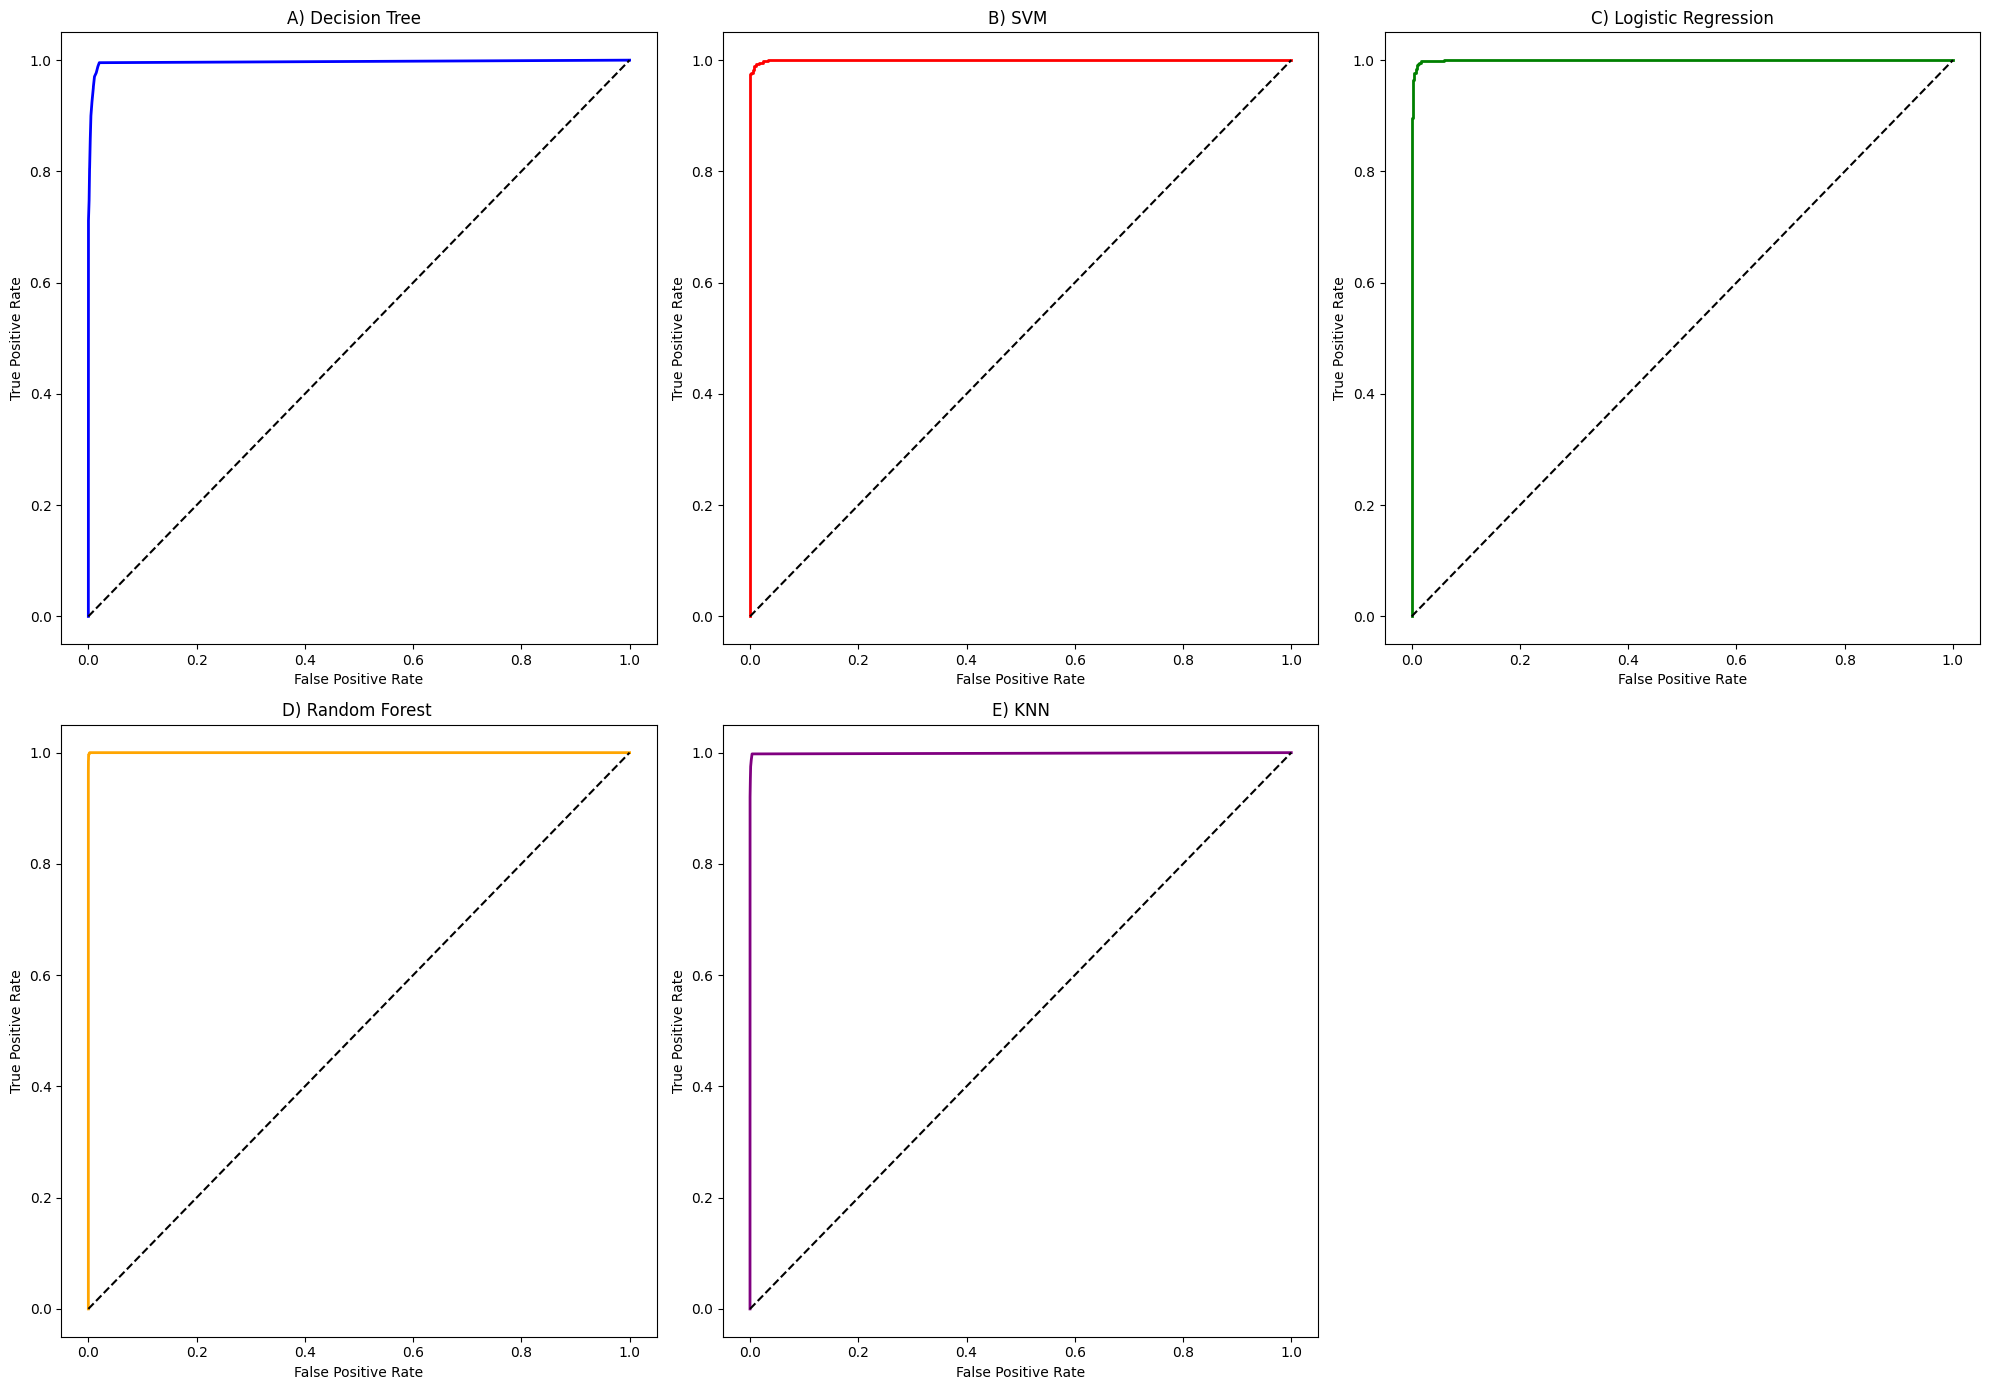

'\n# Print AUC scores at the bottom\nprint("\nAUC Scores:")\nfor letter, model_name, auc_score in auc_scores:\n    print(f"{letter}: {model_name} - AUC = {auc_score:.2f}")\n'

In [9]:
# ROC Curves for All Models in Grid Layout with Letter Labels
colors = ['blue', 'red', 'green', 'orange', 'purple']
models_to_plot = [(name, model) for name, model in zip([m[0] for m in results], [m[5] for m in results]) 
                  if name != "Naive Bayes"]

# Create letter labels and mapping
letters = ['A) Decision Tree  ', 'B) SVM ', 'C) Logistic Regression', 'D) Random Forest ', 'E) KNN']
model_letter_mapping = {letter: model_name for letter, (model_name, _) in zip(letters, models_to_plot)}

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 14))
# fig.suptitle('AUC Scores Comparison', fontsize=16)
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing

# Initialize a list to store AUC scores
auc_scores = []

for idx, ((model_name, model), color, letter) in enumerate(zip(models_to_plot, colors, letters)):
    if model_name == "SVM":
        y_score = model.decision_function(X_test_norm)
    else:
        y_score = model.predict_proba(Xtest)

    # Compute macro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(Ytest_binarized.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot on the corresponding subplot
    axs[idx].plot(fpr, tpr, color=color, lw=2, label=f'AUC = {roc_auc:.2f}')
    axs[idx].plot([0, 1], [0, 1], 'k--', label="Random Guess")
    axs[idx].set_title(f'{letter}')
    axs[idx].set_xlabel('False Positive Rate')
    axs[idx].set_ylabel('True Positive Rate')
    
    # Store the AUC score for later printing
    auc_scores.append((letter.strip(), model_name, roc_auc))


axs[5].remove()

plt.tight_layout()
plt.show()
'''
# Print AUC scores at the bottom
print("\nAUC Scores:")
for letter, model_name, auc_score in auc_scores:
    print(f"{letter}: {model_name} - AUC = {auc_score:.2f}")
'''

Finally, we visualize the performance metrics for each model, comparing them on accuracy, precision, recall, and F1 score to make it easy to identify the best model overall.

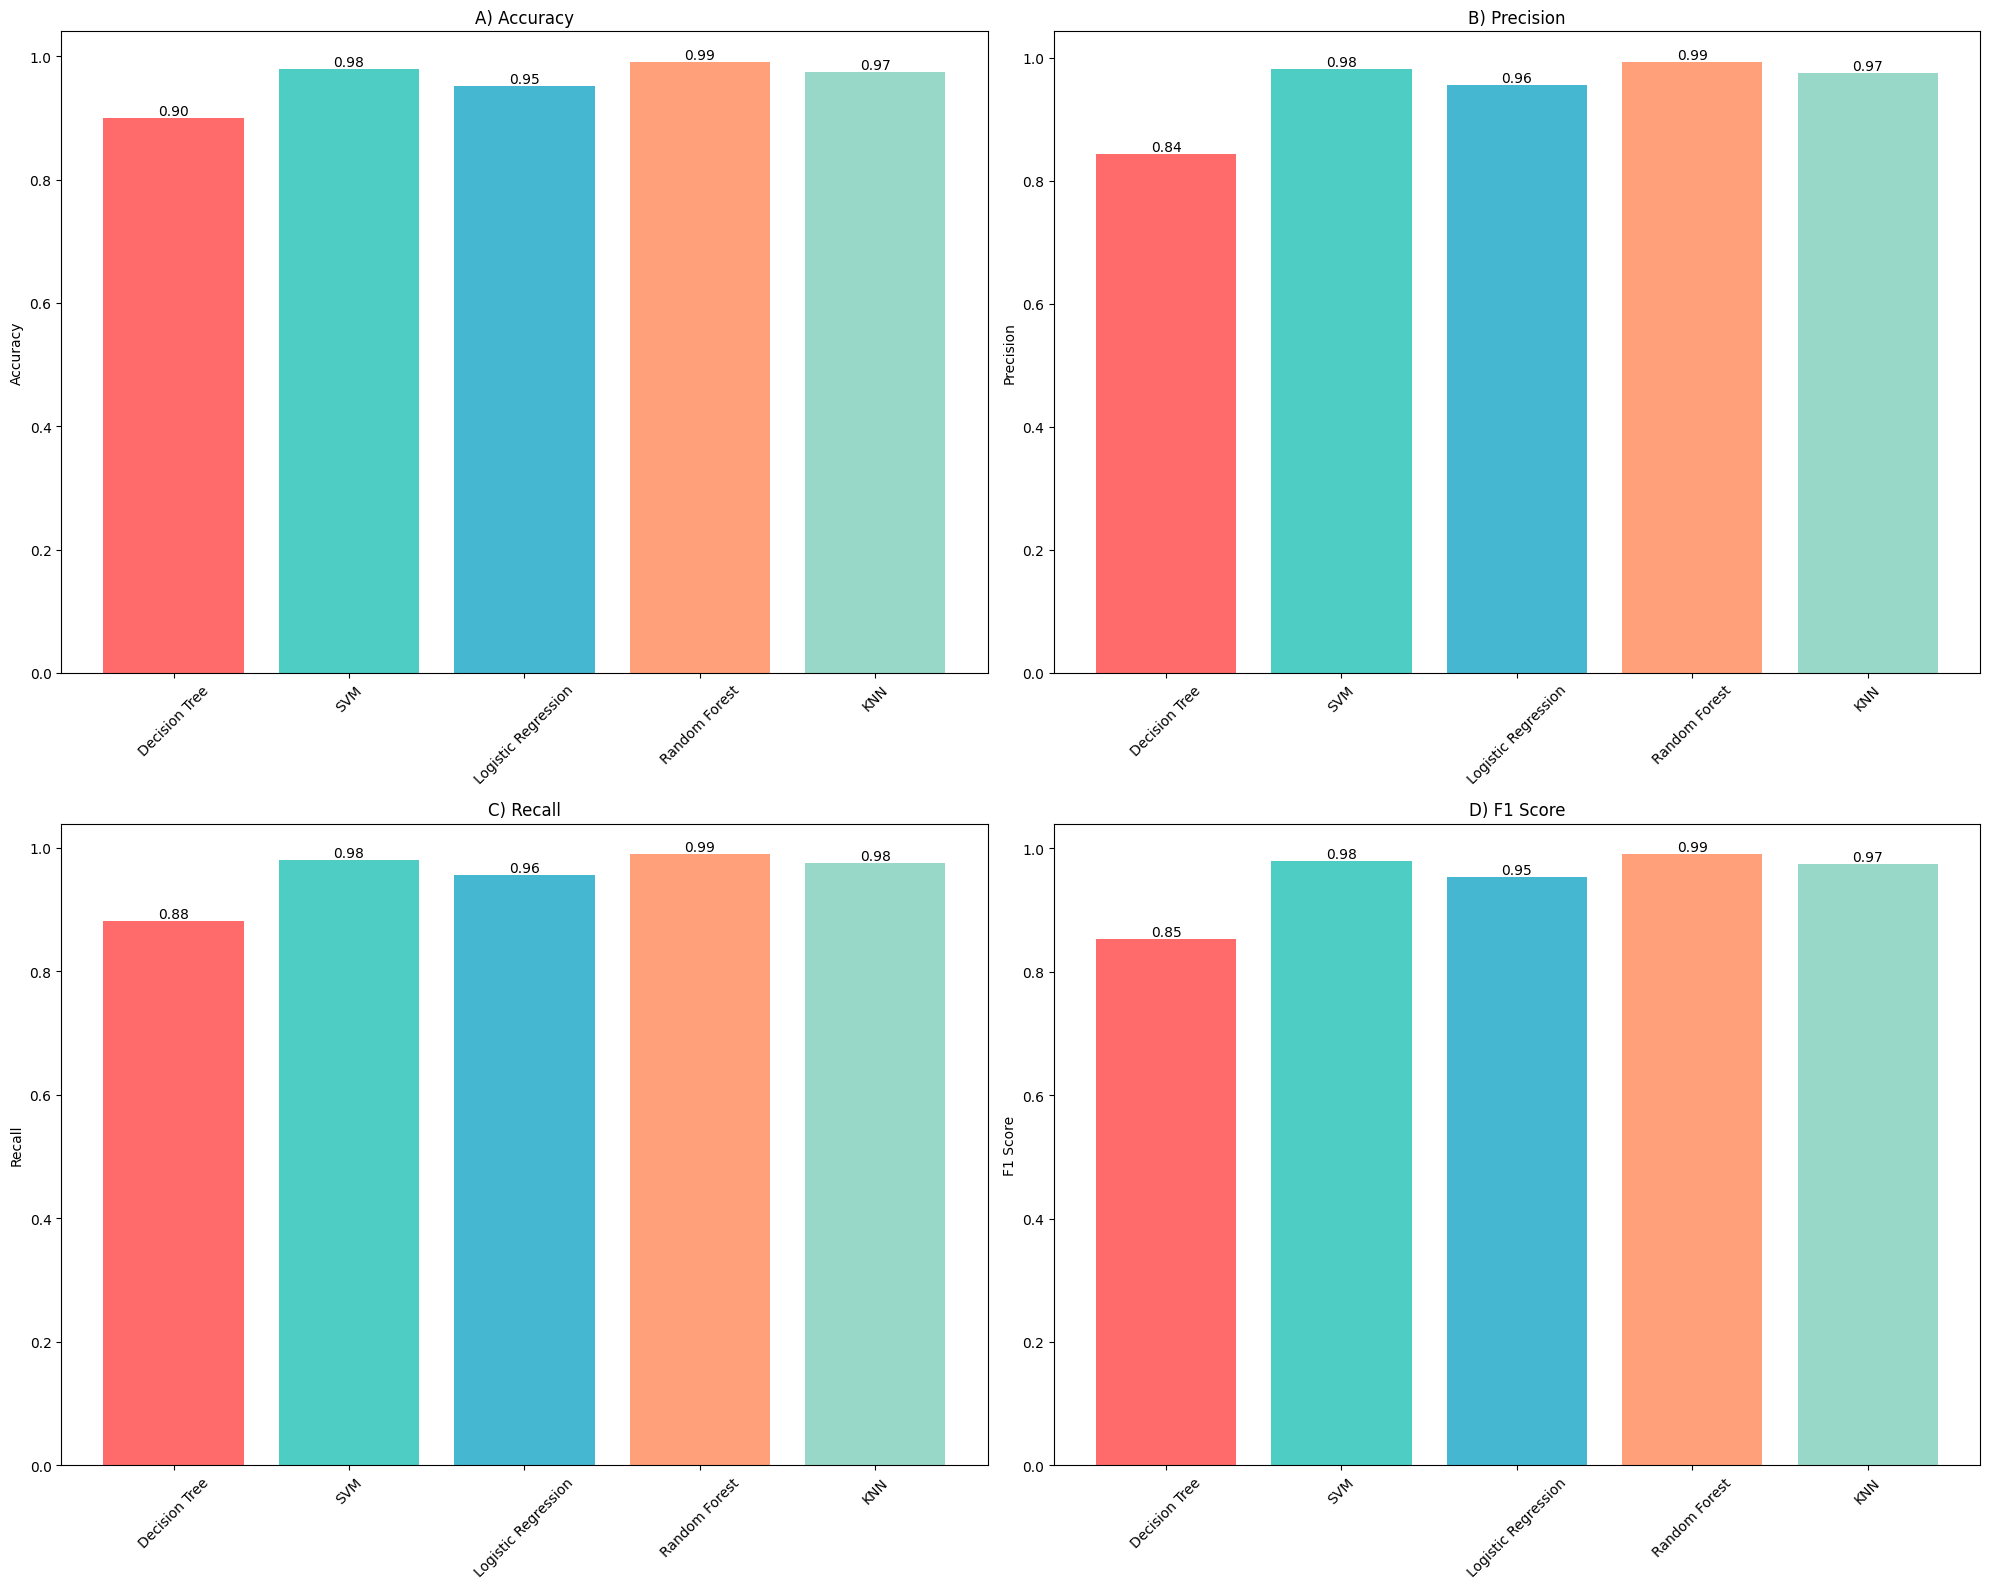

In [10]:
# Performance Metrics Visualization
metrics_data = {
    'Model': [r[0] for r in results],
    'Accuracy': [r[1] for r in results],
    'Precision': [r[2] for r in results],
    'Recall': [r[3] for r in results],
    'F1 Score': [r[4] for r in results]
}

fig, axs = plt.subplots(2, 2, figsize=(20, 16))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
titles = ['A) Accuracy', 'B) Precision', 'C) Recall', 'D) F1 Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axs[idx//2, idx%2]
    bars = ax.bar(metrics_data['Model'], metrics_data[metric], color=colors)
    ax.set_title(title)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


Lastly, we define a function that allows the user to input custom values for various crop-related features and predicts the most suitable crop based on those values. The user can choose from the trained models, and the function will load the selected model, process the input data, and output the crop prediction.

In [11]:
def predict_user_input():
    """
    Handle user input for crop prediction
    """
    try:
        # Get input values
        input_values = {}
        for feature in ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']:
            while True:
                try:
                    value = float(input(f"Enter {feature} value: "))
                    input_values[feature] = value
                    break
                except ValueError:
                    print(f"Please enter a valid number for {feature}")
        
        input_data = pd.DataFrame([input_values])
        
        # Model selection
        print("\nSelect a model to predict:")
        for idx, (name, _) in enumerate(models, 1):
            print(f"{idx}. {name}")
        
        while True:
            try:
                choice = int(input("\nEnter your choice (1-5): "))
                if 1 <= choice <= 5:
                    break
                print("Please select a valid model number (1-5)")
            except ValueError:
                print("Please enter a number")
        
        model_name = models[choice-1][0]
        
        # Load model and make prediction
        with open(f'{model_name}.pkl', 'rb') as f:
            model = pickle.load(f)
            
        if model_name == "SVM":
            input_data_norm = scaler.transform(input_data)
            prediction = model.predict(input_data_norm)
        else:
            prediction = model.predict(input_data)
        
        # Output prediction
        crop_prediction = le.inverse_transform(prediction)
        print(f"\nThe predicted crop is: {crop_prediction[0]}")
        
    except Exception as e:
        print("An error occurred:", e)


In [12]:
predict_user_input()


Select a model to predict:
1. Decision Tree
2. SVM
3. Logistic Regression
4. Random Forest
5. KNN

The predicted crop is: mothbeans


In [ ]:
"""
# Create a single plot for the Random Forest model's ROC curve
model_name = "Random Forest"
model = next((m[5] for m in results if m[0] == model_name), None)

if model is not None:
    # Calculate prediction scores for ROC curve
    y_score = model.predict_proba(Xtest)

    # Compute ROC curve and ROC area for Random Forest
    fpr, tpr, _ = roc_curve(Ytest_binarized.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='green', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.legend(loc='lower right')
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print the AUC score
    print(f"\nAUC Score for {model_name}: {roc_auc:.2f}")
else:
    print("Random Forest model not found.")
"""

'\n# Create a single plot for the Random Forest model\'s ROC curve\nmodel_name = "Random Forest"\nmodel = next((m[5] for m in results if m[0] == model_name), None)\n\nif model is not None:\n    # Calculate prediction scores for ROC curve\n    y_score = model.predict_proba(Xtest)\n\n    # Compute ROC curve and ROC area for Random Forest\n    fpr, tpr, _ = roc_curve(Ytest_binarized.ravel(), y_score.ravel())\n    roc_auc = auc(fpr, tpr)\n\n    # Plot the ROC curve\n    plt.figure(figsize=(10, 8))\n    plt.plot(fpr, tpr, color=\'green\', lw=2, label=f\'{model_name} (AUC = {roc_auc:.2f})\')\n    plt.plot([0, 1], [0, 1], \'k--\', label=\'Random Guess\')\n    plt.title(f\'{model_name} ROC Curve\')\n    plt.xlabel(\'False Positive Rate\')\n    plt.ylabel(\'True Positive Rate\')\n    #plt.legend(loc=\'lower right\')\n    plt.grid()\n\n    # Show the plot\n    plt.tight_layout()\n    plt.show()\n\n    # Print the AUC score\n    print(f"\nAUC Score for {model_name}: {roc_auc:.2f}")\nelse:\n    pr

: 